In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from validation.experimental import  nucleo

In [2]:
t_nucleo_exp_inches = 0.11
t_nucleo_exp = t_nucleo_exp_inches * 25.4

Tau_jorge_inches = 0.191
Tau_jorge = Tau_jorge_inches * 25.4

In [3]:
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [4]:
df = pd.read_csv('../experimental.csv', sep='\t')

In [5]:
df = df[["Nombre","Modulo Tracción [MPa]","Espesor (mm)"]]
# change column names to E[MPa] and t[mm]
df.columns = ['Name', 'E [MPa]', 't [mm]']
# GPa
df["E [GPa]"] = df["E [MPa]"] / 1000
df.drop(columns=["E [MPa]"], inplace=True)
df.head()

,Name,t [mm],E [GPa]
0,TFP1-1,4.9,2.838353
1,TFP1-1,4.9,2.685491
2,TFP1-1,5.0,3.132684
3,TFP2-1,4.4,2.184874
4,TFP2-1,4.6,2.310839


In [6]:
df_stats = df.groupby('Name').agg(['mean', 'std'])
df_stats = df_stats.drop("TFP1-1")

In [7]:
composition = [
        ["X", "Y"],
        ["X", "SX"],
        ["X", "SY"],
        ["X","SX", "SY"],
        ["X","Y", "SY"]
    ]
df_stats["layers"] = composition

In [8]:
df_stats

t [mm]             E [GPa]                 layers
            mean       std      mean       std             
Name                                                       
TFP2-1  4.500000  0.100000  2.258503  0.065626       [X, Y]
TFP3-1  4.900000  0.200000  2.000437  0.004435      [X, SX]
TFP4-1  4.500000  0.000000  2.451362  0.114353      [X, SY]
TFP5-1  5.733333  0.115470  1.626582  0.120272  [X, SX, SY]
TFP6-1  5.533333  0.057735  1.739870  0.067515   [X, Y, SY]

<Axes: title={'center': 'Modulo Tracción [GPa]'}, xlabel='Name'>

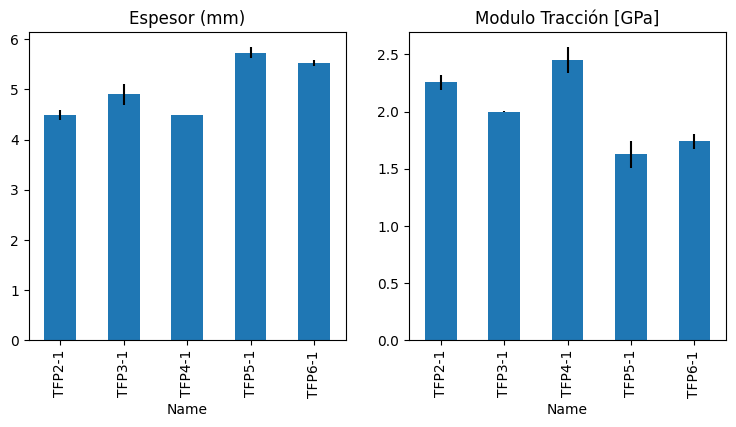

In [9]:
# plot bars with error bars Espesor (mm)
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)
df_stats['t [mm]'].plot(kind='bar', y='mean', yerr='std', legend=False, title='Espesor (mm)', ax=ax)
# plot bars with error bars Modulo Tracción [MPa]
ax = fig.add_subplot(122)
df_stats['E [GPa]'].plot(kind='bar', y='mean', yerr='std', legend=False, title='Modulo Tracción [GPa]', ax=ax)

In [10]:
df_stats

t [mm]             E [GPa]                 layers
            mean       std      mean       std             
Name                                                       
TFP2-1  4.500000  0.100000  2.258503  0.065626       [X, Y]
TFP3-1  4.900000  0.200000  2.000437  0.004435      [X, SX]
TFP4-1  4.500000  0.000000  2.451362  0.114353      [X, SY]
TFP5-1  5.733333  0.115470  1.626582  0.120272  [X, SX, SY]
TFP6-1  5.533333  0.057735  1.739870  0.067515   [X, Y, SY]

In [11]:
# [X]       -> [1,0,0,0]
# [X, SX]   -> [1,0,1,0]
# [X, Y]    -> [1,1,0,0]
# [X, SY]       -> [1,0,0,1]
# [X, SX, SY]   -> [1,0,1,1]
# [X, Y, SY]    -> [1,1,0,1]

def get_vector(list_of_layers):
    vector = [0,0,0,0]
    if "X" in list_of_layers:
        vector[0] = 1
    if "SX" in list_of_layers:
        vector[1] = 1
    if "Y" in list_of_layers:
        vector[2] = 1
    if "SY" in list_of_layers:
        vector[3] = 1

    return vector


In [12]:
df_stats['v [X,Y,SX,SY]'] = df_stats['layers'].apply(get_vector)
df_stats["ni"] = df_stats["layers"].apply(len)
df_stats

t [mm]             E [GPa]                 layers v [X,Y,SX,SY] ni
            mean       std      mean       std                              
Name                                                                        
TFP2-1  4.500000  0.100000  2.258503  0.065626       [X, Y]  [1, 0, 1, 0]  2
TFP3-1  4.900000  0.200000  2.000437  0.004435      [X, SX]  [1, 1, 0, 0]  2
TFP4-1  4.500000  0.000000  2.451362  0.114353      [X, SY]  [1, 0, 0, 1]  2
TFP5-1  5.733333  0.115470  1.626582  0.120272  [X, SX, SY]  [1, 1, 0, 1]  3
TFP6-1  5.533333  0.057735  1.739870  0.067515   [X, Y, SY]  [1, 0, 1, 1]  3

In [13]:
ni = df_stats["ni"].values
tau_exp = df_stats["t [mm]"]["mean"].values
print(ni )
tau_pred_fcn = lambda tn,tl: tn + tl*ni

[2 2 2 3 3]


In [14]:
# min square error

from scipy.optimize import minimize,basinhopping
def objective(tn,tl):
    return sum((tau_pred_fcn(tn,tl) - tau_exp)**2)


In [15]:

from Composite.CreateLines.BasicLines import BasicLines


lines = {
    "r": 2.5,
    "Nx_sq": 1,
    "Ny_sq": 1,
    "type":  'sin' # 'circle' or 'sin'
}

lines = BasicLines(lines)

/tmp/ipykernel_32318/4169359739.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for j,layer in enumerate(df_stats['layers'][i]):


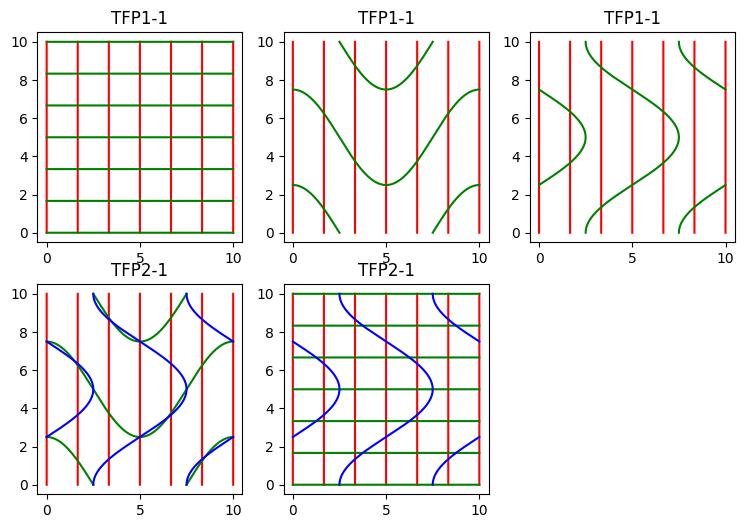

In [16]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
fig = plt.figure(figsize=(9,6))
for i in range(len(df_stats)):
    plt.subplot(2, 3, i+1)

    for j,layer in enumerate(df_stats['layers'][i]):
        for curve in lines["trajs_"+layer]:
            plt.plot(curve[:,0], 
                     curve[:,1],
                     color = colors[j],
                        label = layer) 
    plt.title(df['Name'][i])
    

In [17]:
def E_effective_j(tn,tl,En,Evec,j):
    
    tau_pred = tau_pred_fcn(tn,tl)

    delta_j  = df_stats["v [X,Y,SX,SY]"].iloc[j]

    tau_j    = tau_pred[j]

    return (En*tn + tl*(np.dot(delta_j,Evec)))/tau_j

def E_effective(En,Evec,tn,tl):
    return np.array([E_effective_j(tn,tl,En,Evec,j) 
                     for j in range(len(df_stats))])


In [18]:
E_eff_exp = df_stats["E [GPa]"]["mean"].values

Evec_0 = np.array([1,0,0,0])
En_0 = 100
tn_0 = 1
tl_0 = 1

E_eff_pred = E_effective(En_0,Evec_0,tn_0,tl_0)
tau_pred = tau_pred_fcn(tn_0,tl_0)

In [19]:
tau_pred

array([3, 3, 3, 4, 4])

In [20]:
def theta(x):
    return 0.5*(np.sign(x)+1)


In [21]:
# minimize 
def objective_E(En,Evec,tn,tl):
    Loss_E   = sum((E_effective(En,Evec,tn,tl) - E_eff_exp)**2)
    Loss_tau = sum((tau_pred_fcn(tn,tl) - tau_exp)**2)
    
    # En < Evec[0]
    lag_mult = 1e6*theta( En - Evec[0]) # Asumimos que el nucleo es el material más blando que la capas E[0] -> X
    
    return Loss_E + Loss_tau + lag_mult
           

x0 = np.random.rand(7)
# must be positive 

bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.0100,None), # Evec[0]   # X
            (0.0100,None), # Evec[1]   # Y
            (0.0100,None), # Evec[2]   # SX
            (0.0100,None), # Evec[3]   # SY
            (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
            (0.25,2)  # tl
            ]
          
# set constraints
if x0[1] < x0[0]:
    x0[1] = x0[0]

for k,ib in enumerate(bounds):

    if ib[0] is not None and x0[k] < ib[0]:
        x0[k] = ib[0]
    if ib[1] is not None and x0[k] > ib[1]:
        x0[k] = ib[1]


In [22]:

minimize_kwargs = {
    'method': 'trust-constr',
    'bounds': bounds
}

res = basinhopping(lambda x: objective_E(x[0],x[1:5],x[5],x[6]),
                x0, 
                minimizer_kwargs= minimize_kwargs,
                niter=10,
                stepsize=0.5,
                seed=0)

En_opt = res.x[0]
Evec_opt = res.x[1:5]
tn_opt = res.x[5]
tl_opt = res.x[6]


E_eff_pred = E_effective(En_opt,Evec_opt,tn_opt,tl_opt)
tau_pred   = tau_pred_fcn(tn_opt,tl_opt)

/home/djoroya/Documents/CITISENS_Composite/.conda/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


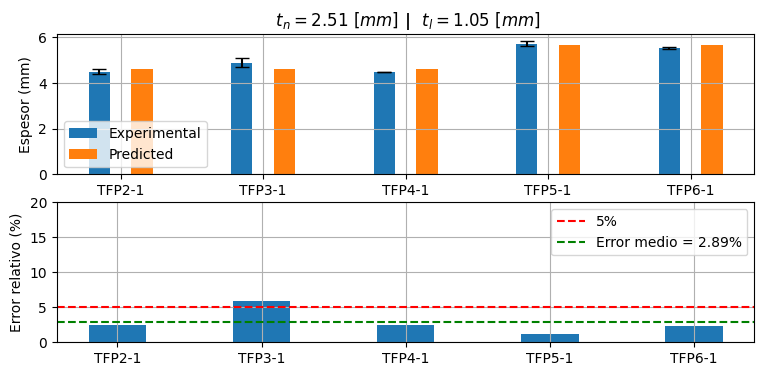

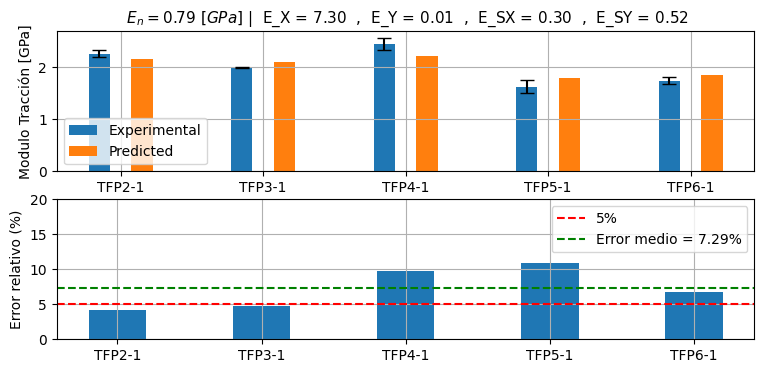

In [23]:
from AnalyticalLayers.plot_E import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [24]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","Y","SX","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(2)

,Evec [GPa]
X,7.30
Y,0.01
SX,0.30
SY,0.52
Nucleo,0.79


In [25]:
print("Optimal En: ", En_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  0.7939266395602099
Optimal tn:  2.5146001276687233
Optimal tl:  1.0492089307037442


In [26]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals
df_pred = df_pred.round(2)
df_pred.head()

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP2-1,2.16,2.26,4.24,4.61,4.50,2.51
1,TFP3-1,2.10,2.00,4.79,4.61,4.90,5.86
2,TFP4-1,2.21,2.45,9.79,4.61,4.50,2.51
3,TFP5-1,1.80,1.63,10.88,5.66,5.73,1.24
4,TFP6-1,1.86,1.74,6.76,5.66,5.53,2.33


In [27]:
df_stats

t [mm]             E [GPa]                 layers v [X,Y,SX,SY] ni
            mean       std      mean       std                              
Name                                                                        
TFP2-1  4.500000  0.100000  2.258503  0.065626       [X, Y]  [1, 0, 1, 0]  2
TFP3-1  4.900000  0.200000  2.000437  0.004435      [X, SX]  [1, 1, 0, 0]  2
TFP4-1  4.500000  0.000000  2.451362  0.114353      [X, SY]  [1, 0, 0, 1]  2
TFP5-1  5.733333  0.115470  1.626582  0.120272  [X, SX, SY]  [1, 1, 0, 1]  3
TFP6-1  5.533333  0.057735  1.739870  0.067515   [X, Y, SY]  [1, 0, 1, 1]  3